In [1]:
import os
from concurrent.futures import ThreadPoolExecutor
from pathlib import Path

import numpy as np
import scyjava
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from jpype.types import JArray, JDouble, JLong, JInt

import neuron_tracing_utils.util.java
scyjava.start_jvm()

from neuron_tracing_utils.util.ioutil import open_ts
from neuron_tracing_utils.util.java import snt
from neuron_tracing_utils.util.ioutil import OmeZarrReader

from neuron_tracing_utils.util.swcutil import swc_to_ndarray
from neuron_tracing_utils.util.sntutil import ndarray_to_graph
from neuron_tracing_utils.util.java.imglib2 import Point, LinAlgHelpers, Views

In [2]:
def _thread_worker(ts, swcs):
    xs, ys, zs = [], [], []
    for swc in swcs:
        t = snt.Tree(swc)
        # prepare the vertex xyz coordinates for vectorized indexing
        for path in t.list():
            for i in range(path.size()):
                v = path.getNode(i)
                xs.append(int(v.getX() / 0.748))
                ys.append(int(v.getY() / 0.748))
                zs.append(int(v.getZ()))
        # get the values from the image
    all_vals = ts[zs, ys, xs].read().result().tolist()
    print(sum(all_vals)/len(all_vals))
    return all_vals

In [3]:
def get_swc_intensities(swcs, ts, threads=8):
    # split the swcs into chunks
    chunks = np.array_split(swcs, threads)
    # create a thread pool
    with ThreadPoolExecutor(max_workers=threads) as executor:
        # submit the chunks to the thread pool
        futures = [executor.submit(_thread_worker, ts, chunk) for chunk in chunks]
        # wait for the threads to finish
        results = [future.result() for future in futures]
    # flatten the results
    return [item for sublist in results for item in sublist]

In [4]:
# walk through the directory and find all the swc files
path = r"C:\Users\cameron.arshadi\repos\exaSPIM-training-data\653980-eval\swcs\errors"
omits = []
splits = []
correct = []
for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith(".swc"):
            if root.endswith("omit"):
                omits.append(os.path.join(root, file))
            elif root.endswith("split"):
                splits.append(os.path.join(root, file))
            elif root.endswith("correct"):
                correct.append(os.path.join(root, file))
            else:
                raise ValueError(f"unexpected directory {root}")

print(len(omits), len(splits), len(correct))

16562 7866 25963


In [5]:
impath = "https://s3.us-west-2.amazonaws.com/aind-open-data/exaSPIM_653980_2023-08-10_20-08-29_fusion_2023-08-24/fused.zarr"
ts = open_ts(impath, "0")
ts = ts[0, 0, :, :, :]

In [6]:
# save values to a numpy file
if os.path.isfile(os.path.join(path, "vals_omit.npy")):
    vals_omit = np.load(os.path.join(path, "vals_omit.npy"))
else:
    vals_omit = get_swc_intensities(omits, ts)
    np.save(os.path.join(path, "vals_omit.npy"), vals_omit)
    
if os.path.isfile(os.path.join(path, "vals_split.npy")):
    vals_split = np.load(os.path.join(path, "vals_split.npy"))
else:
    vals_split = get_swc_intensities(splits, ts)
    np.save(os.path.join(path, "vals_split.npy"), vals_split)

if os.path.isfile(os.path.join(path, "vals_correct.npy")):
    vals_correct = np.load(os.path.join(path, "vals_correct.npy"))
else:
    vals_correct = get_swc_intensities(correct, ts)
    np.save(os.path.join(path, "vals_correct.npy"), vals_correct)

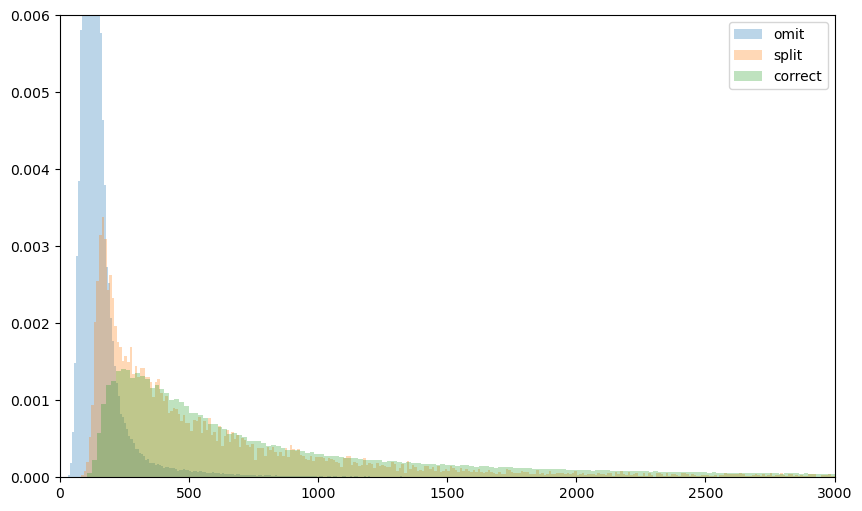

In [7]:
# create a histogram of the values
plt.figure(figsize=(10,6))
plt.hist(vals_omit, bins=2000, alpha=0.3, label="omit", density=True)
plt.hist(vals_split, bins=2000, alpha=0.3, label="split", density=True)
plt.hist(vals_correct, bins=2000, alpha=0.3, label="correct", density=True)
plt.xlim(0, 3000)
plt.ylim(0, 0.006)
plt.legend(loc='upper right')
plt.show()

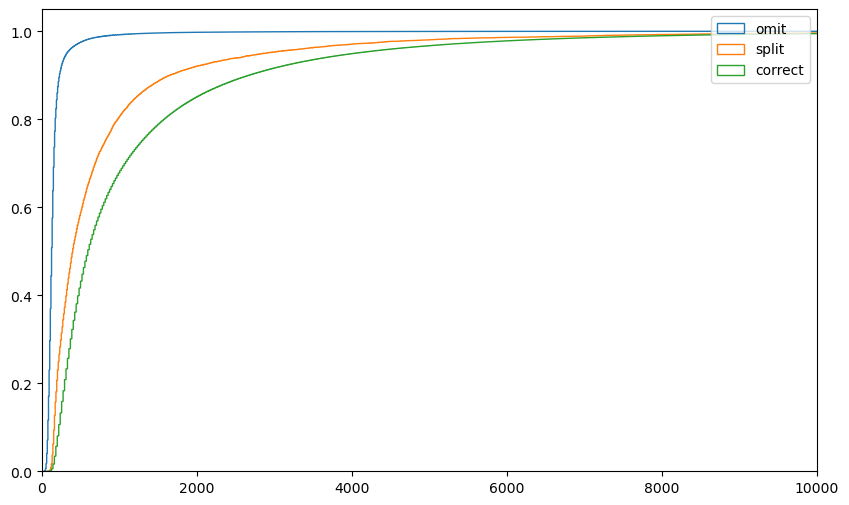

In [8]:
# CDF
plt.figure(figsize=(10,6))
plt.hist(vals_omit, bins=2000, alpha=1, label="omit", density=True, cumulative=True, histtype="step")
plt.hist(vals_split, bins=2000, alpha=1, label="split", density=True, cumulative=True, histtype="step")
plt.hist(vals_correct, bins=2000, alpha=1, label="correct", density=True, cumulative=True, histtype="step")
plt.xlim(0, 10000)
plt.legend(loc='upper right')
plt.show()

         pixel_value error_class
0                398        omit
1                521        omit
2                758        omit
3                548        omit
4                321        omit
...              ...         ...
2983317          527     correct
2983318          579     correct
2983319          479     correct
2983320          318     correct
2983321          177     correct

[2983322 rows x 2 columns]


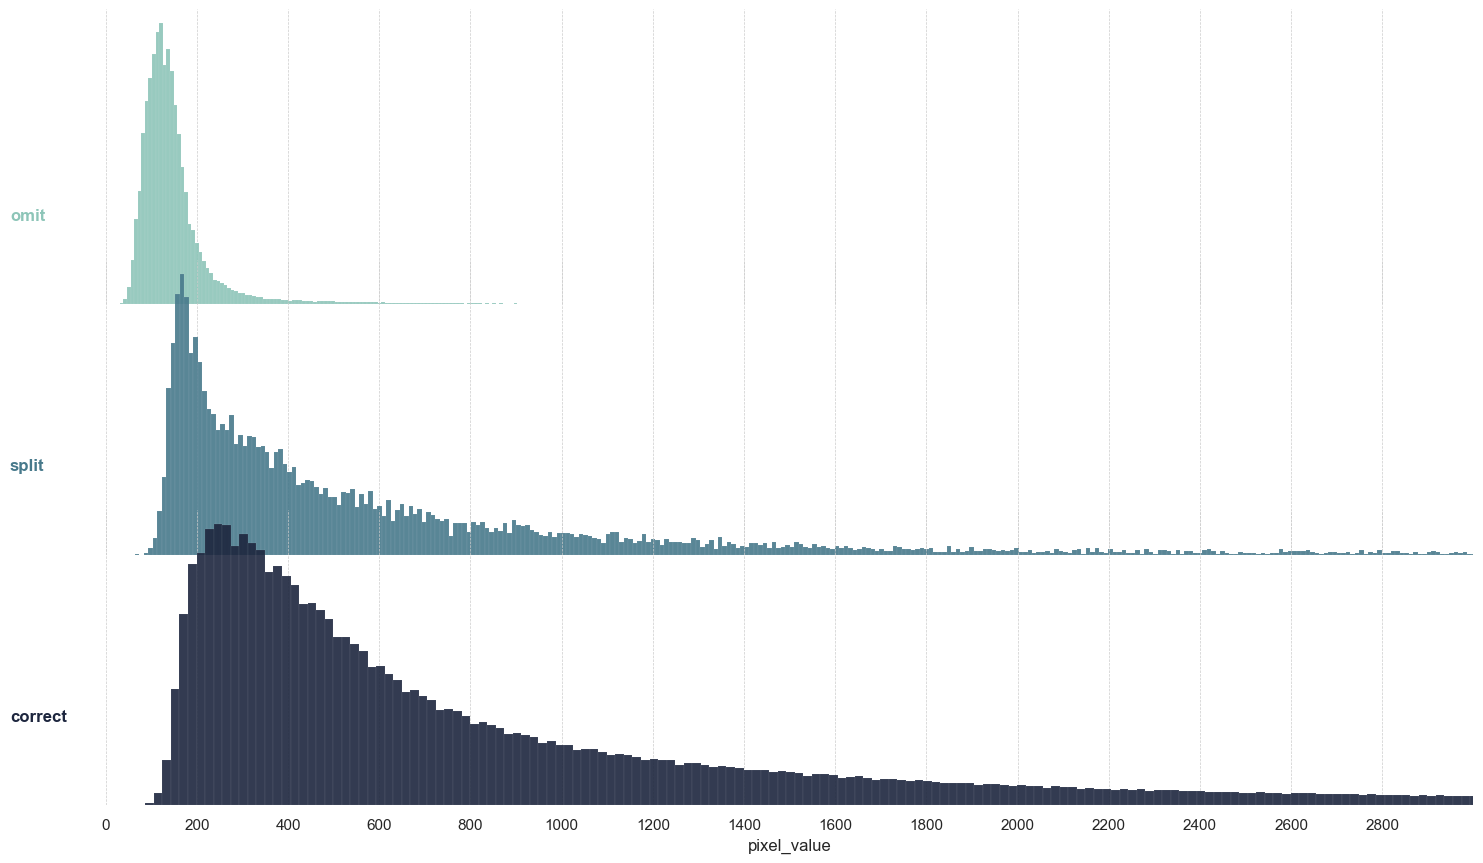

In [9]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create individual dataframes
df_omit = pd.DataFrame({'pixel_value': vals_omit, 'error_class': 'omit'})
df_split = pd.DataFrame({'pixel_value': vals_split, 'error_class': 'split'})
df_correct = pd.DataFrame({'pixel_value': vals_correct, 'error_class': 'correct'})

# Concatenate dataframes
df = pd.concat([df_omit, df_split, df_correct], ignore_index=True)

print(df)

pal = sns.cubehelix_palette(3, rot=-.33, light=0.7)
g = sns.FacetGrid(
    df, 
    sharex=True, 
    sharey=False, 
    row="error_class", 
    hue="error_class", 
    aspect=5, 
    height=3, 
    palette=pal, 
    row_order=['omit', 'split', 'correct']
)

g.map(sns.histplot, "pixel_value", stat="density", bins=2000, fill=True, alpha=0.9)

def label(x, color, label):
    ax = plt.gca()
    ax.text(-0.07, .3, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "pixel_value")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.15)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], xticks=np.arange(0, 3000, 200), xlim=(0, 3000), ylabel="")
g.despine(bottom=True, left=True)

for ax in g.axes.flat:
    ax.grid(True, which='both', axis='x', linestyle='--', linewidth=0.5)

In [14]:

path = r"C:\Users\cameron.arshadi\OneDrive - Allen Institute\overlap-intensity-analysis"
impath = "s3://aind-open-data/exaSPIM_653980_2023-08-10_20-08-29_fusion_2023-08-24/fused.zarr"

rai = OmeZarrReader().load(impath, key="0")
rai = Views.hyperSlice(rai, 3, 0)
rai = Views.hyperSlice(rai, 3, 0)
ra = rai.randomAccess()
print(rai.dimensionsAsLongArray())

data = {}

for folder in Path(path).iterdir():
    swcs = [f for f in folder.iterdir() if f.name.endswith('.swc')]
    trees = [ndarray_to_graph(swc_to_ndarray(str(f), add_offset=True)).getTree() for f in swcs]
    case_vals = []
    tangent = JArray(JDouble)(3)
    pos = JArray(JLong)(3)
    for t in trees:
        for p in t.list():
            bkg_vals = []
            path_vals = []
            for i in range(p.size()):
                p.getTangent(i, 1, tangent)
                if tangent[0] == 0 and tangent[1] == 0 and tangent[2] == 0:
                    continue
                LinAlgHelpers.normalize(tangent)
                
                pos[0] = int(p.getXUnscaled(i) / 0.748)
                pos[1] = int(p.getYUnscaled(i) / 0.748)
                pos[2] = int(p.getZUnscaled(i))
                
                skel_val = ra.setPositionAndGet(pos).get()
                path_vals.append(skel_val)
                
                cursor = snt.CircleCursor3D(rai, Point(pos), 20, tangent)
                while cursor.hasNext():
                    cursor.fwd()
                    try:
                        val = cursor.get().get()
                    except Exception as e:
                        print(e)
                    else:
                        bkg_vals.append(val)
                        
            bkg_avg = sum(bkg_vals) / len(bkg_vals)
            noise = np.std(bkg_vals)
            # print(bkg_avg, noise)

            for val in path_vals:
                signal = val - bkg_avg
                snr = signal / noise if noise != 0 else 0
                case_vals.append(snr)
                
    data[folder.name] = case_vals
    print(folder.name, sum(case_vals) / len(case_vals))

[62654, 29005, 23146]
omitted-nonoverlap 4.74237229056605
omitted-overlap 5.030834290122272
predicted-nonoverlap 12.266303789313122
predicted-overlap 36.76769165764483


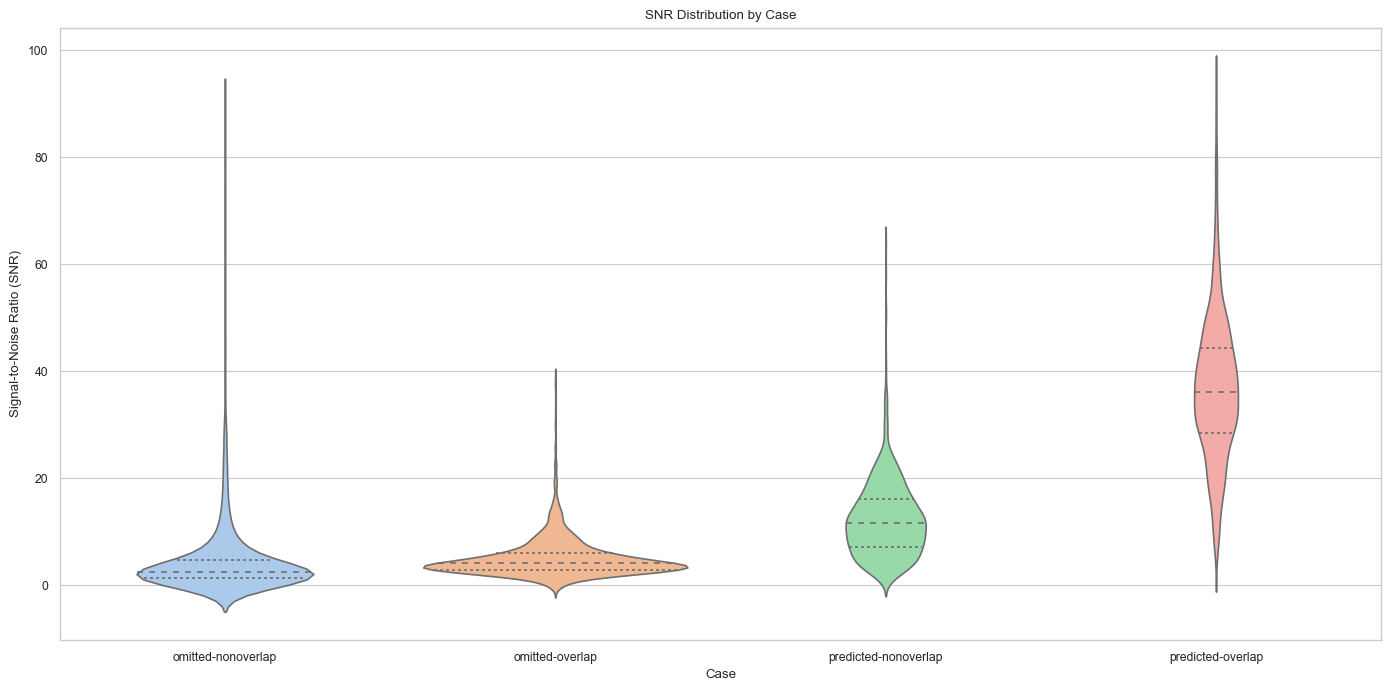

In [22]:
# Convert the dictionary to a pandas DataFrame
df = pd.DataFrame.from_dict(data, orient='index').transpose().melt(var_name='Case', value_name='SNR').dropna()

sns.set_style("whitegrid")
sns.set_context("paper")  # or "paper", "notebook", or "poster"

plt.figure(figsize=(14, 7))

sns.violinplot(x="Case", y="SNR", data=df, inner="quart", palette="pastel", order=sorted(data.keys()))

plt.title('SNR Distribution by Case')
plt.ylabel('Signal-to-Noise Ratio (SNR)')
plt.xlabel('Case')

# Optionally, adjust y-axis limits
# plt.ylim([lower_bound, upper_bound])

plt.tight_layout()
plt.show()
